<a href="https://colab.research.google.com/github/KKeshav1101/HateSpeechDetection-MiniProject/blob/main/HateSpeechDetection_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hate Speech Detection using LSTMs on a balanced dataset

First two attempts failed miserably due to overfitting and no amount of pre-processing or data-augmentation could provide us could results. So a larger datatset was found and this was balanced so the usage of SMOTE became unnecessary. A simple LSTM on the dataset gave very good results. Next, we aim to employ a transformer and an ensemble of LSTM and GRUs to see if it significantly improves the results.

## Import Necessary Libraries

In [52]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import  Input,Dense,Embedding, LSTM,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

## Load Dataset

Source : [Hate Speech Detection Curated Dataset](https://www.kaggle.com/datasets/waalbannyantudre/hate-speech-detection-curated-dataset) <br> The dataset was very good in comparison to the previous ones used. The large number of rows made sure that overfitting was avoided without having to do data augmentation. To top it off, a balanced dataset was available to reduce any bias.

In [53]:
file = "HateSpeechDatasetBalanced.csv"
df = pd.read_csv(file)
df.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


In [60]:
df.tail()

,Content,Label,ProcessedContent
726114,i mute this telecasting and played kanye west ...,1,mute telecasting played kanye west clique know...
726115,but hell yeah he s not a bachelor but looooooo...,1,hell yeah bachelor loooooooooooooooooooooooooo...
726116,great video musician but s not my musician lol...,1,great video musician musician lollllllllllllll...
726117,not great pop video yeah he s not a pedophile ...,1,great pop video yeah pedophile yeah lollllllll...
726118,great video yeah he s non a paedophile lolllll...,1,great video yeah non paedophile lollllllllllll...


In [54]:
df.shape

(726119, 2)

In [56]:
df['Label'].unique()

array([1, 0])

## Preprocessing Text

In [57]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [58]:
stp = set(stopwords.words("english"))

# Function to preprocess text
def preprocess_text(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    words = [word for word in text if word not in stp]
    return " ".join(words)
df['ProcessedContent'] = df['Content'].apply(preprocess_text)

### Tokenization

In [59]:
from keras._tf_keras.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['ProcessedContent'])
sequences = tokenizer.texts_to_sequences(df['ProcessedContent'])

In [61]:
max_len=max([max(0,len(seq)) for seq in sequences])
max_len

294

### Padding Sequences <br>
> Ensures all sequences are of same length

In [62]:
from keras._tf_keras.keras.preprocessing.sequence import pad_sequences
x = pad_sequences(sequences, maxlen=max_len)
y = df['Label'].values

In [63]:
print(x.shape)
print(y.shape)

(726119, 294)
(726119,)


## Splitting into Train and Test Set

In [64]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(580895, 294)
(145224, 294)
(580895,)
(145224,)


## Model Creation

In [65]:
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [66]:
#Creating the model
i = Input(shape=(x_train.shape[1],))
x = Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=20)(i)
x = LSTM(10,return_sequences=True)(x)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(1,activation='sigmoid')(x)
model = Model(i,x)

# Using Adam optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

# Compiling the model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Fitting the model
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test),batch_size=64)

Epoch 1/5
9077/9077 ━━━━━━━━━━━━━━━━━━━━ 201s 22ms/step - accuracy: 0.8107 - loss: 0.4023 - val_accuracy: 0.8609 - val_loss: 0.3148
Epoch 2/5
9077/9077 ━━━━━━━━━━━━━━━━━━━━ 199s 22ms/step - accuracy: 0.8827 - loss: 0.2717 - val_accuracy: 0.8655 - val_loss: 0.3120
Epoch 3/5
9077/9077 ━━━━━━━━━━━━━━━━━━━━ 201s 21ms/step - accuracy: 0.9015 - loss: 0.2321 - val_accuracy: 0.8666 - val_loss: 0.3184
Epoch 4/5
9077/9077 ━━━━━━━━━━━━━━━━━━━━ 203s 22ms/step - accuracy: 0.9094 - loss: 0.2133 - val_accuracy: 0.8660 - val_loss: 0.3325
Epoch 5/5
9077/9077 ━━━━━━━━━━━━━━━━━━━━ 202s 22ms/step - accuracy: 0.9124 - loss: 0.2053 - val_accuracy: 0.8617 - val_loss: 0.3414


## Analyzing Training History

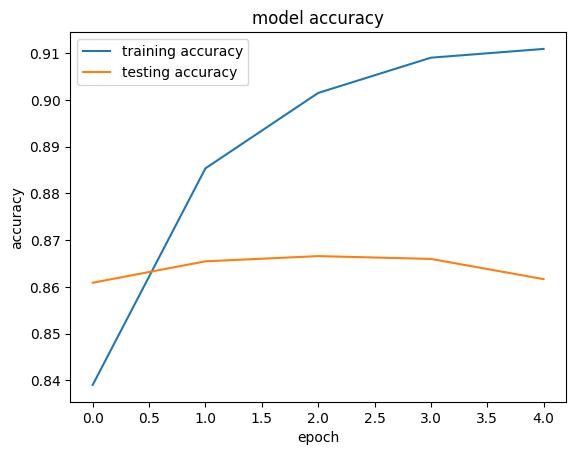

In [67]:
plt.plot(history.history["accuracy"],label="training accuracy")
plt.plot(history.history["val_accuracy"],label="testing accuracy")
plt.title("model accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

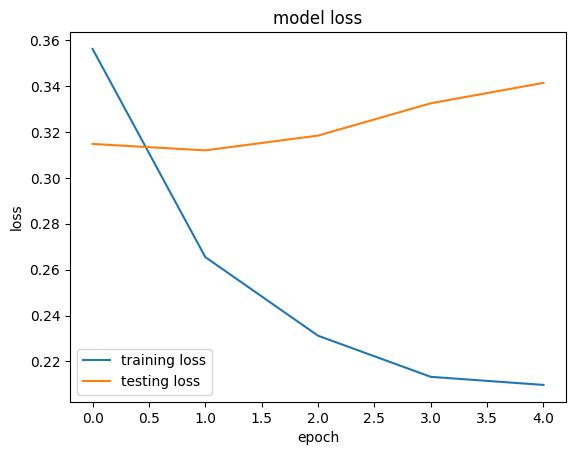

In [68]:
plt.plot(history.history["loss"],label="training loss")
plt.plot(history.history["val_loss"],label="testing loss")
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

## Model Evaluation

In [69]:
y_pred = model.predict(x_test)
y_pred.shape

4539/4539 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step


(145224, 1)

In [70]:
y_pred = y_pred.squeeze()

In [71]:
y_pred_binary = np.where(y_pred>0.5,1,0)
y_pred_binary

array([0, 1, 1, ..., 1, 0, 1])

In [72]:
loss,accuracy = model.evaluate(x_test, y_test)
print("model loss",loss)
print("model accuracy",accuracy)

4539/4539 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.8620 - loss: 0.3390
model loss 0.3414257764816284
model accuracy 0.8616688847541809


In [73]:
from sklearn.metrics import accuracy_score,confusion_matrix
print(f"the accuracy score is:{accuracy_score(y_pred_binary,y_test)}")

the accuracy score is:0.8616688701592023


## Confusion Matrix

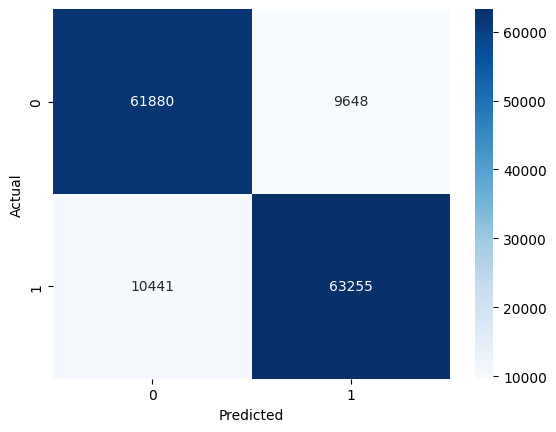

In [75]:
import seaborn as sns
con= confusion_matrix(y_pred_binary,y_test)
sns.heatmap(con,annot=True,fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Classification Report

In [77]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86     72321
           1       0.86      0.87      0.86     72903

    accuracy                           0.86    145224
   macro avg       0.86      0.86      0.86    145224
weighted avg       0.86      0.86      0.86    145224



This has clearly been our best result and we hope to find improvisations with ensemble techniques such as bagging and parallelization of the same.